In [2]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [4]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [5]:
from os import listdir
from os.path import isfile, join
import glob

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [6]:
mypath = '/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Test_Data_750.h5',
 '/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Train_Data_750.h5']

In [8]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[fold_no*2+1],'r')
    hf_Test = h5.File(my_files8[fold_no*2],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [9]:
#class_names = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [10]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

In [11]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 4))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)

    x2=Flatten()(x)

    x3=Dense(128,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(32,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=inputs1, outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [12]:
# 750*4 input
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_conv(512, 20, 128, 5)
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, verbose=0, callbacks=[es])
    model.save_weights("Checkpoints/New_%i_fold_weights_750.h5" %i)
    y = model.predict(X_test)
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.8765822784810127, 0.8704807692307692, 0.8815270834097855, 0.8729338931447939, 0.8664998187297199)
(0.884493670886076, 0.8781730769230769, 0.8859768853352971, 0.8796102624609022, 0.8751126256888763)
(0.884493670886076, 0.8833653846153846, 0.886835389335094, 0.8827902422477923, 0.8752288974195375)
(0.8591772151898734, 0.8535576923076923, 0.8567179228830979, 0.8539720061547005, 0.8474184098663471)
(0.8908227848101266, 0.8860576923076924, 0.8887134183554184, 0.8867684646798721, 0.8817118766873381)
(0.8892405063291139, 0.8827884615384616, 0.8912060768325124, 0.8851744921331879, 0.8802496505349228)
(0.865506329113924, 0.85625, 0.8714427808430167, 0.8587028534568456, 0.8546035306484562)
(0.870253164556962, 0.864326923076923, 0.8695095054107225, 0.8644564391387883, 0.8597615445755544)
(0.8829113924050633, 0.8766346153846154, 0.8860358034224454, 0.8782719850240223, 0.8733797491410368)
(0.8639240506329114, 0.8590384615384614, 0.8633672389761211, 0.8592626943700281, 0.8528322090937245)


In [13]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.8767405063291139
0.8710673076923076
0.8781332104803511
0.8721943332810934
0.8666798312385513


In [28]:
# 750*4 input
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_conv(512, 20, 128, 5)
    #es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    #history = model.fit(X_train[:,:,0:4], Y_train, validation_data=(X_test[:,:,0:4], Y_test), epochs=500, verbose=0, callbacks=[es])
    #model.save_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
    model.load_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
    y = model.predict(X_test)
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    #history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.8781645569620253, 0.8728846153846155, 0.8755602839043255, 0.8730856066770796, 0.868123631082572)
(0.8781645569620253, 0.8737499999999999, 0.8771327632023146, 0.874133340410673, 0.8681002636399964)
(0.8876582278481012, 0.8847115384615385, 0.8909603929529416, 0.8863469735821577, 0.8783730472363609)
(0.865506329113924, 0.8597115384615385, 0.8605725418538266, 0.8580704971536328, 0.854597776978746)
(0.8734177215189873, 0.8717307692307693, 0.872601376238488, 0.8703966161926826, 0.86310631322221)
(0.879746835443038, 0.8726923076923078, 0.8779206446916084, 0.8734140453849466, 0.8697841055888254)
(0.8876582278481012, 0.883846153846154, 0.888139545871379, 0.8846266189630341, 0.8784645901488461)
(0.8813291139240507, 0.8742307692307691, 0.8898069999763423, 0.8779966305605884, 0.8719022052910316)
(0.884493670886076, 0.8781730769230769, 0.8858414194977782, 0.8801333995134529, 0.874931593527689)
(0.8876582278481012, 0.8803846153846155, 0.8915663640438173, 0.8821657131306526, 0.8785655778257427)


In [24]:
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)

In [29]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.8803797468354431
0.8752115384615387
0.8810102332232821
0.8760369441568902
0.870594910454202


In [30]:
np.std(auc_mat_750c1[:,0], ddof=1)

0.007123182707229591

Confusion matrix, without normalization


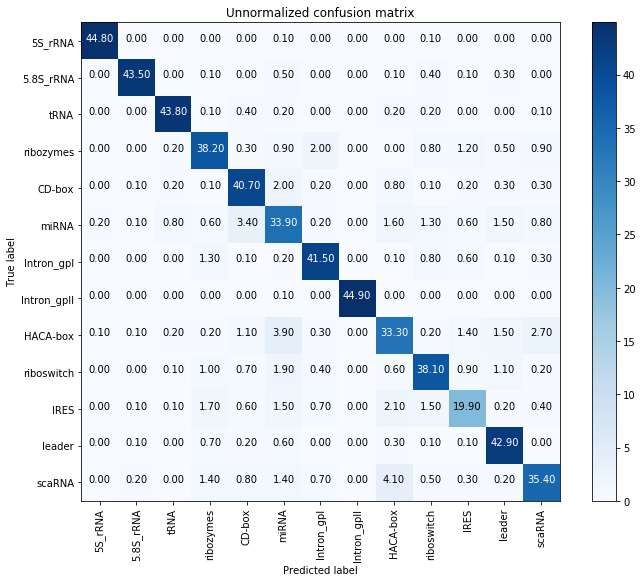

In [19]:
conf_mat_750s = np.array(conf_mat_750c1)
conf_mat_sum = conf_mat_750s[0,0,:,:]
for i in range(2,10):
    conf_mat_sum = conf_mat_sum + conf_mat_750s[i,0,:,:]
conf_mat_avg = np.true_divide(conf_mat_sum,10)
conf_mat_avg.dtype
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=False,
                        title='Unnormalized confusion matrix')

Normalized confusion matrix


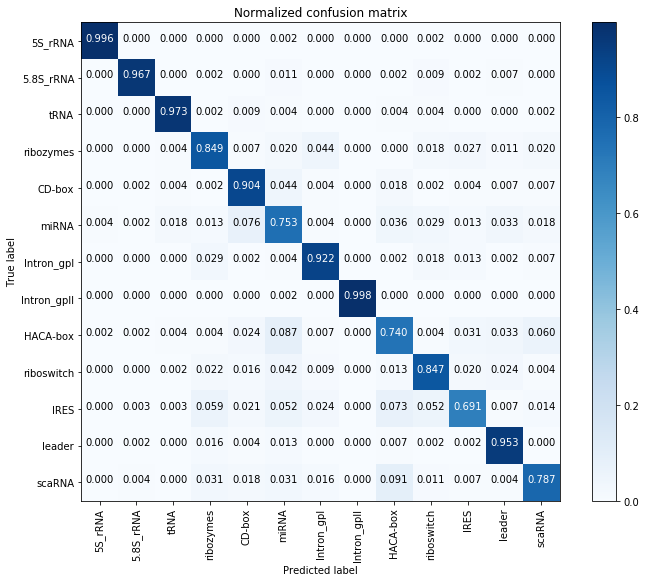

In [20]:
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')

In [22]:
for i in range(10):
    print(class_report_750c1['fold%i'%i])

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       0.96      0.94      0.95        50
           2       0.96      0.94      0.95        50
           3       0.85      0.78      0.81        50
           4       0.94      0.92      0.93        50
           5       0.70      0.80      0.75        50
           6       0.93      0.84      0.88        50
           7       1.00      1.00      1.00        50
           8       0.82      0.72      0.77        50
           9       0.88      0.88      0.88        50
          10       0.69      0.69      0.69        32
          11       0.92      0.96      0.94        50
          12       0.77      0.88      0.82        50

   micro avg       0.88      0.88      0.88       632
   macro avg       0.88      0.87      0.87       632
weighted avg       0.88      0.88      0.88       632

              precision    recall  f1-score   support

           0       0.98 

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 750, 4)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 731, 512)          41472     
_________________________________________________________________
batch_normalization_37 (Batc (None, 731, 512)          2048      
_________________________________________________________________
dropout_37 (Dropout)         (None, 731, 512)          0         
_________________________________________________________________
activation_37 (Activation)   (None, 731, 512)          0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 365, 512)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 361, 128)          327808    
__________

In [16]:
mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)

In [17]:
mcc

0.8528322090937245

In [20]:
confusion_matrix

array([[49,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 49,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 43,  1,  1,  3,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 46,  3,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  2,  0,  5, 38,  1,  1,  0,  0,  0,  1,  1],
       [ 0,  0,  0,  4,  0,  1, 40,  0,  1,  3,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  2,  7,  0,  0, 37,  0,  1,  1,  1],
       [ 0,  0,  0,  2,  0,  3,  0,  0,  0, 43,  1,  1,  0],
       [ 0,  1,  0,  3,  1,  1,  3,  0,  1,  1, 21,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 49,  0],
       [ 0,  1,  0,  2,  0,  3,  1,  0,  4,  0,  0,  0, 39]])

In [30]:
i=0
X_train, Y_train, X_test, Y_test = get_file8(i)
model = model_conv(512, 20, 128, 5)
model.load_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
y = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]

In [53]:
for j in range(13):
    (tn, fp, fn, tp) = (0,0,0,0)
    classnum = j
    for i in range(len(y_test_non_category)):

         if (y_test_non_category[i]==classnum and y_predict_non_category[i] ==classnum):
                 tp+=1
         elif (y_test_non_category[i]==classnum and y_predict_non_category[i] !=classnum):
                 fn+=1
         elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] ==classnum):
                 fp+=1
         elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] !=classnum):
                tn+=1
    val = (tp * tn) - (fp * fn)
    val = val / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    print(val)

0.9788943792140632
0.9452603464894838
0.9452603464894838
0.7979293581807385
0.9233404617393056
0.7262922816425782
0.8762483741323857
1.0
0.7490185879886803
0.8696907216494846
0.6708333333333333
0.9362280862717675
0.8081499226587369


In [55]:
for k in range(10):
    i=k
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_conv(512, 20, 128, 5)
    model.load_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
    y = model.predict(X_test)
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    for j in range(13):
        (tn, fp, fn, tp) = (0,0,0,0)
        classnum = j
        for i in range(len(y_test_non_category)):

             if (y_test_non_category[i]==classnum and y_predict_non_category[i] ==classnum):
                     tp+=1
             elif (y_test_non_category[i]==classnum and y_predict_non_category[i] !=classnum):
                     fn+=1
             elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] ==classnum):
                     fp+=1
             elif (y_test_non_category[i]!=classnum and y_predict_non_category[i] !=classnum):
                    tn+=1
        val = (tp * tn) - (fp * fn)
        val = val / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        print(val)
    print("***************")

0.9788943792140632
0.9452603464894838
0.9452603464894838
0.7979293581807385
0.9233404617393056
0.7262922816425782
0.8762483741323857
1.0
0.7490185879886803
0.8696907216494846
0.6708333333333333
0.9362280862717675
0.8081499226587369
***************
0.9559886552816865
0.9565635738831615
0.9677738014792473
0.8601601336393422
0.8082292074448804
0.6799187805331267
0.913127147766323
1.0
0.7149892512366975
0.8656255306843488
0.7569483924357727
0.9049944149992527
0.8575808074887714
***************
0.9891001159898399
0.9891001159898399
0.9892965350472283
0.8418842826272038
0.8914089347079038
0.7041416142375247
0.8960264001068056
1.0
0.7479813837378809
0.7868960609737324
0.8433815987862844
0.8695431534208559
0.863209648696872
***************
0.9891001159898399
0.9670467864480431
0.9462510679112662
0.8674763742769948
0.8508955003871761
0.6657572557143354
0.8935617933294717
1.0
0.6749271644944826
0.8295623539160282
0.6492764780081822
0.8656819473347682
0.8262542955326461
***************
1.0
0.9677

In [56]:
from sklearn.metrics import roc_auc_score

In [116]:
i=7
X_train, Y_train, X_test, Y_test = get_file8(i)
model = model_conv(512, 20, 128, 5)
model.load_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
y = model.predict(X_test)

In [59]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

In [81]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(13):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [83]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for k in range(10):
    i=k
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_conv(512, 20, 128, 5)
    model.load_weights("Checkpoints/%i_fold_weights_750c1.h5" %i)
    y = model.predict(X_test)
    for j in range(13):
        fpr[i,j], tpr[i,j], _ = roc_curve(Y_test[:, j], y[:, j])
        roc_auc[i,j] = auc(fpr[i,j], tpr[i,j])

In [84]:
fpr

{(0, 0): array([0., 0., 0., 1.]),
 (0, 1): array([0.        , 0.        , 0.        , 0.00171821, 0.00171821,
        0.00343643, 0.00343643, 0.0257732 , 0.0257732 , 1.        ]),
 (0, 2): array([0.        , 0.        , 0.        , 0.01030928, 0.01030928,
        0.01202749, 0.01202749, 1.        ]),
 (0, 3): array([0.        , 0.        , 0.        , 0.00171821, 0.00171821,
        0.00343643, 0.00343643, 0.00515464, 0.00515464, 0.00859107,
        0.00859107, 0.04295533, 0.04295533, 0.05670103, 0.05670103,
        0.06872852, 0.06872852, 0.07044674, 0.07044674, 0.0790378 ,
        0.0790378 , 0.08591065, 0.08591065, 0.12542955, 0.12542955,
        0.18041237, 0.18041237, 0.1838488 , 0.1838488 , 1.        ]),
 (0, 4): array([0.        , 0.        , 0.        , 0.00171821, 0.00171821,
        0.00343643, 0.00343643, 0.00687285, 0.00687285, 0.02061856,
        0.02061856, 0.03780069, 0.03780069, 0.04639175, 0.04639175,
        0.12027491, 0.12027491, 1.        ]),
 (0, 5): array([0.    

In [105]:
for k in range(10):
    print(len(fpr[k,1]))
    #len()

10
8
6
10
8
4
8
10
6
4


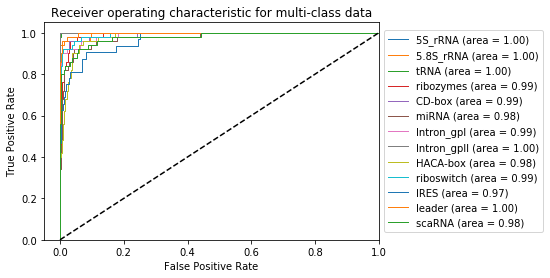

In [109]:
k=7
for i in range(13):
    plt.plot(fpr[k,i], tpr[k,i], lw=1,
             label='{0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[k,i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1]:
for i in range(13):
    plt.plot(fpr[i], tpr[i], lw=1,
             label='{0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'plt' is not defined

In [70]:
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [71]:
class_names[i]

'scaRNA'

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

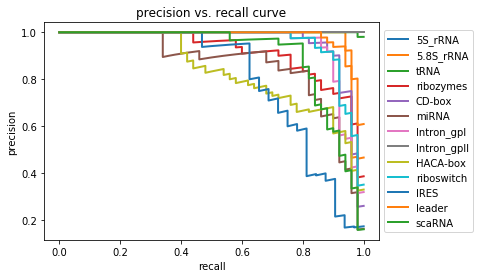

In [117]:
precision = dict()
recall = dict()
for i in range(13):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(class_names[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("precision vs. recall curve")
plt.show()